# Description du Notebook
-------------
**Objectifs** : Visualiser les données patient par patient puis dans leur ensemble. Repérer les données extrêmes et les corriger.

**Visualisation des données** : Scatter plots, Régression Polynomiale

## Sommaire
-------------
- [Import des données et des packages](#import)
- [Z-score vs Isolation Forest](#z-vs-if)
- [Interprétation des graphiques](#interpret)

<a id="import"></a>

## Import des données et des packages [(^)](#up)
--------------

In [62]:
import pandas as pd
import numpy as np
import timeit

from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings  
warnings.filterwarnings('ignore')

start = timeit.default_timer()

data = pd.read_csv('data/age_interval/data20_70.csv', dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')
ipprs = pd.read_csv('plots/iForest/ippr_iForest.csv', dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')
ipprs= ipprs.IPPR

<a id="z-vs-if"></a>

## Z-score vs Isolation Forest [(^)](#up)
---------------------

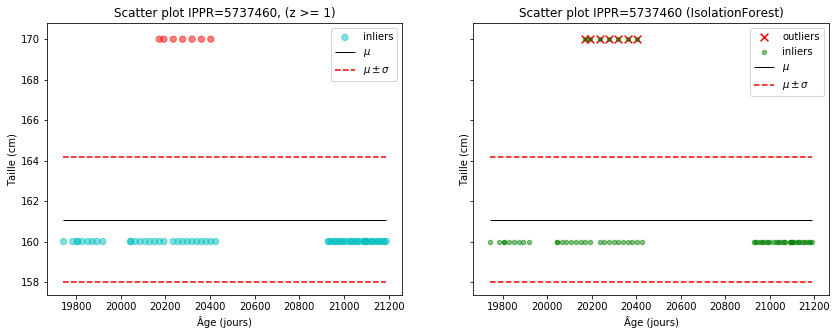

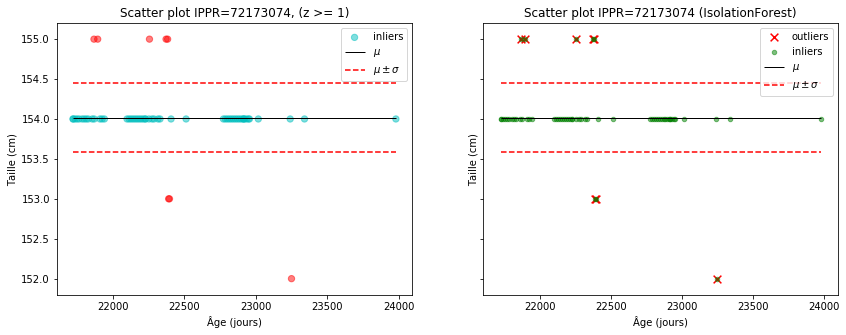

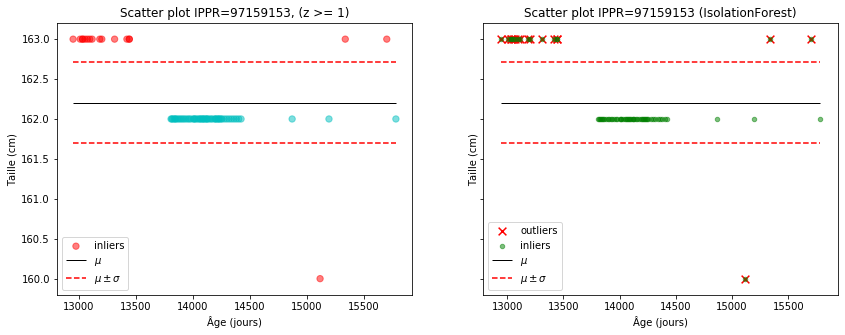

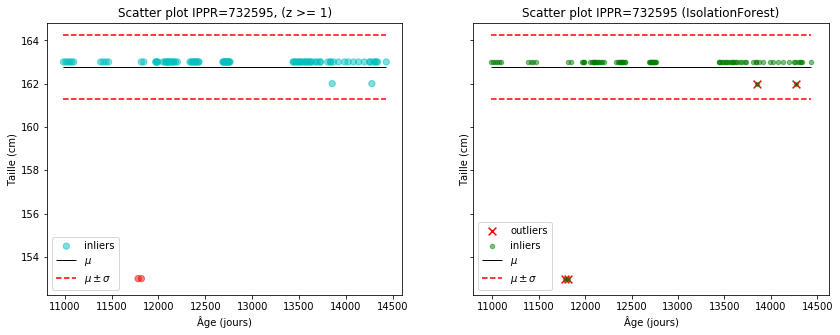

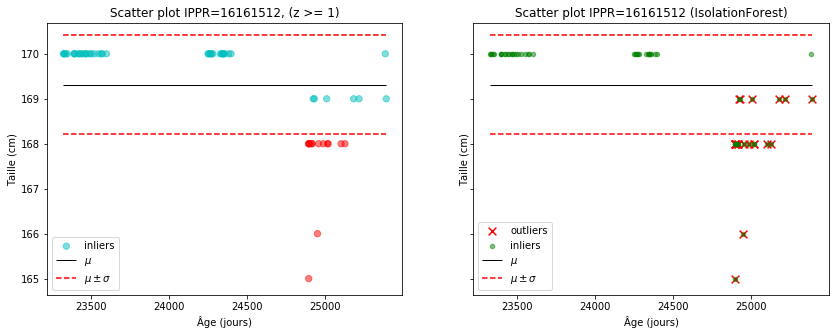

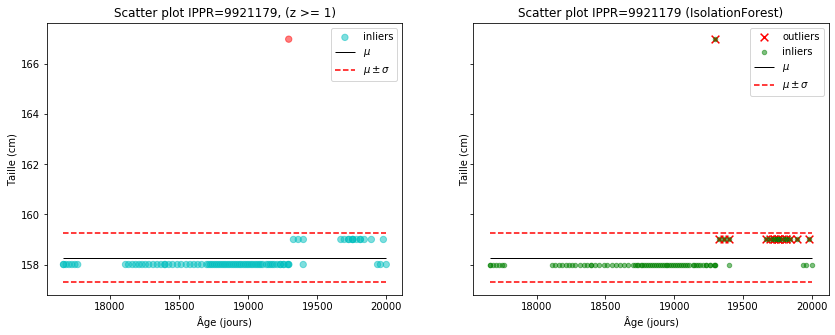

In [81]:
# calculating Z-score
def z_score(df, ippr):
    df = df[df['IPPR'] == ippr]
    x = df['Taille']
    z = zscore(x)
    return z
    
########################## Zscore
def zscore_iforest(ipprs):
    for ippr in ipprs:
        # print(ippr)
        df = data[data['IPPR'] == ippr]
        x = df.age_at_entry
        y = df.Taille
        # print(x)
        
        z = z_score(data, ippr)
        if z.any() > 0:
            # print('z : {}'.format(z))
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
            
            # mean, std
            mu = np.mean(y)
            theta = np.std(y)
            
            col = np.where((z<=1.0) & (z>=-1.0), 'c', 'r')
            
            ax[0].scatter(x, y, color=col, alpha=0.5, s=40, label='inliers')
            ax[0].hlines(mu, x.iloc[0], x.iloc[len(x)-1],'k', linewidth=1, label='$\mu$')
            ax[0].hlines(mu+theta, x.iloc[0], x.iloc[len(x)-1],'r', linestyles='dashed', label='$\mu \pm \sigma$')
            ax[0].hlines(mu-theta, x.iloc[0], x.iloc[len(x)-1], 'r', linestyles='dashed')
            ax[0].legend()
            ax[0].set_title('Scatter plot IPPR={}, (z >= 1)'.format(ippr))
            ax[0].set_xlabel("Âge (jours)")
            ax[0].set_ylabel("Taille (cm)")
        
        
        ############################################ iForest
        # -------------------------------- Modelling
        df = data[data['IPPR'] == ippr]
        X_train = df.Taille
        X_train = np.array(X_train)
        X_train = X_train.reshape(-1, 1)

        # iForest model design
        clf = IsolationForest(max_samples='auto', random_state=0)
        # Training
        clf.fit(X_train)
        # Prediction output
        pred = clf.predict(X_train)
        score = clf.score_samples(X_train)
        df['otl'] = pred                  # Binary (-1 if otl else 1)
        df['score'] = abs(score)          # -1 < otl score < 0


        # -------------------------------- Plotting
        X_train = df.Taille # array to df
        age = df.age_at_entry
        otl = df.loc[df['otl'] == -1]
        otl_index=list(otl.index) # index of outliers
        ax[1].scatter(age[otl_index], X_train[otl_index], marker= 'x', c='r', s=60, label='outliers')
        ax[1].scatter(age, X_train, c='green', alpha=0.5, s=20, label='inliers')
        ax[1].hlines(mu, x.iloc[0], x.iloc[len(x)-1],'k', linewidth=1, label='$\mu$')
        ax[1].hlines(mu+theta, x.iloc[0], x.iloc[len(x)-1],'r', linestyles='dashed', label='$\mu \pm \sigma$')
        ax[1].hlines(mu-theta, x.iloc[0], x.iloc[len(x)-1], 'r', linestyles='dashed')
        ax[1].legend()
        ax[1].set_title('Scatter plot IPPR={} (IsolationForest)'.format(ippr))
        ax[1].set_xlabel("Âge (jours)")
        ax[1].set_ylabel("Taille (cm)")
         
zscore_iforest(ipprs)

<a id="interpret"></a>

## Interprétation des graphiques [(^)](#up)
-------------

Au regard des graphiques ci-dessus, la méthode de l'**Isolation Forest** semble plus précise pour détecter les anomalies.

> IPPR = [732595, 16161512, 9921179]

<span style="color:red"> **Attention!**</span> Ses méthodes ne sont utilisable uniquement pour les patients agés de +20 ans, chez qui la taille ne varie plus.


